# Dark matter spatial and spectral models

## Introduction 

Gammapy has some convenience methods for dark matter analyses in `~gammapy.astro.darkmatter`. These include J-Factor computation and calculation the expected gamma flux for a number of annihilation channels. They are presented in this notebook. 

The basic concepts of indirect dark matter searches, however, are not explained. So this is aimed at people who already know what the want to do. A good introduction to indirect dark matter searches is given for example in https://arxiv.org/pdf/1012.4515.pdf (Chapter 1 and 5)

## Setup

As always, we start with some setup for the notebook, and with imports.

In [1]:
from gammapy.astro.darkmatter import (
    profiles,
    JFactory,
    PrimaryFlux,
    DarkMatterAnnihilationSpectralModel,
)

from gammapy.maps import WcsGeom, WcsNDMap
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
from regions import CircleSkyRegion
import astropy.units as u
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## Profiles

The following dark matter profiles are currently implemented. Each model can be scaled to a given density at a certain distance. These parameters are controlled by ``profiles.DMProfile.LOCAL_DENSITY`` and ``profiles.DMProfile.DISTANCE_GC``

In [3]:
profiles.DMProfile.__subclasses__()

[gammapy.astro.darkmatter.profiles.NFWProfile,
 gammapy.astro.darkmatter.profiles.EinastoProfile,
 gammapy.astro.darkmatter.profiles.IsothermalProfile,
 gammapy.astro.darkmatter.profiles.BurkertProfile,
 gammapy.astro.darkmatter.profiles.MooreProfile]

LOCAL_DENSITY: 0.3 GeV / cm3
DISTANCE_GC: 8.33 kpc


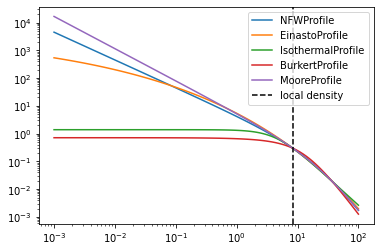

In [4]:
for profile in profiles.DMProfile.__subclasses__():
    p = profile()
    p.scale_to_local_density()
    radii = np.logspace(-3, 2, 100) * u.kpc
    plt.plot(radii, p(radii), label=p.__class__.__name__)

plt.loglog()
plt.axvline(8.5, linestyle="dashed", color="black", label="local density")
plt.legend()

print("LOCAL_DENSITY:", profiles.DMProfile.LOCAL_DENSITY)
print("DISTANCE_GC:", profiles.DMProfile.DISTANCE_GC)

## J Factors

There are utilities to compute J-Factor maps can can serve as a basis to compute J-Factors for certain regions. In the following we compute a J-Factor map for the Galactic Centre region

In [5]:
profile = profiles.NFWProfile()

# Adopt standard values used in HESS
profiles.DMProfile.DISTANCE_GC = 8.5 * u.kpc
profiles.DMProfile.LOCAL_DENSITY = 0.39 * u.Unit("GeV / cm3")

profile.scale_to_local_density()

position = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
geom = WcsGeom.create(binsz=0.05, skydir=position, width=3.0, frame="galactic")

In [6]:
jfactory = JFactory(
    geom=geom, profile=profile, distance=profiles.DMProfile.DISTANCE_GC
)
jfact = jfactory.compute_jfactor()

No handles with labels found to put in legend.


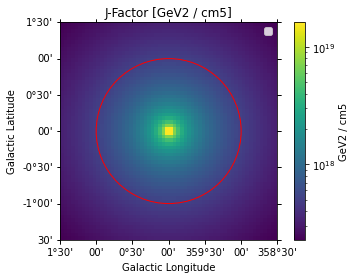

In [7]:
jfact_map = WcsNDMap(geom=geom, data=jfact.value, unit=jfact.unit)
fig, ax, im = jfact_map.plot(cmap="viridis", norm=LogNorm(), add_cbar=True)
plt.title(f"J-Factor [{jfact_map.unit}]")

# 1 deg circle usually used in H.E.S.S. analyses
sky_reg = CircleSkyRegion(center=position, radius=1 * u.deg)
pix_reg = sky_reg.to_pixel(wcs=geom.wcs)
pix_reg.plot(ax=ax, facecolor="none", edgecolor="red", label="1 deg circle")
plt.legend()

In [8]:
# NOTE: https://arxiv.org/abs/1607.08142 quote 2.67e21 without the +/- 0.3 deg band around the plane
total_jfact = pix_reg.to_mask().multiply(jfact).sum()
print(
    "J-factor in 1 deg circle around GC assuming a "
    f"{profile.__class__.__name__} is {total_jfact:.3g}"
)

J-factor in 1 deg circle around GC assuming a NFWProfile is 1.35e+21 GeV2 / cm5


## Gamma-ray spectra at production

The gamma-ray spectrum per annihilation is a further ingredient for a dark matter analysis. The following annihilation channels are supported. For more info see https://arxiv.org/pdf/1012.4515.pdf

In [9]:
fluxes = PrimaryFlux(mDM="1 TeV", channel="eL")
print(fluxes.allowed_channels)

['eL', 'eR', 'e', 'muL', 'muR', 'mu', 'tauL', 'tauR', 'tau', 'q', 'c', 'b', 't', 'WL', 'WT', 'W', 'ZL', 'ZT', 'Z', 'g', 'gamma', 'h', 'nu_e', 'nu_mu', 'nu_tau', 'V->e', 'V->mu', 'V->tau']


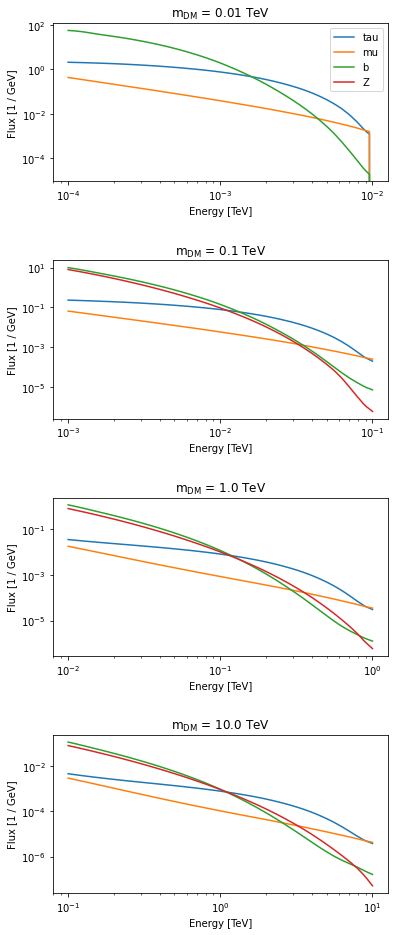

In [10]:
fig, axes = plt.subplots(4, 1, figsize=(6, 16))
mDMs = [0.01, 0.1, 1, 10] * u.TeV

for mDM, ax in zip(mDMs, axes):
    fluxes.mDM = mDM
    ax.set_title(rf"m$_{{\mathrm{{DM}}}}$ = {mDM}")
    ax.set_yscale("log")
    ax.set_ylabel("dN/dE")

    for channel in ["tau", "mu", "b", "Z"]:
        fluxes.channel = channel
        fluxes.table_model.plot(
            energy_range=[mDM / 100, mDM],
            ax=ax,
            label=channel,
            flux_unit="1/GeV",
        )

axes[0].legend()
plt.subplots_adjust(hspace=0.5)

## Flux maps

Finally flux maps can be produced like this:

In [11]:
channel = "Z"
massDM = 10 * u.TeV
diff_flux = DarkMatterAnnihilationSpectralModel(mass=massDM, channel=channel)
int_flux = (
    jfact * diff_flux.integral(energy_min=0.1 * u.TeV, energy_max=10 * u.TeV)
).to("cm-2 s-1")

Text(0.5, 1.0, 'Flux [1 / (cm2 s)]\n m$_{DM}$=10.0 TeV, channel=Z')

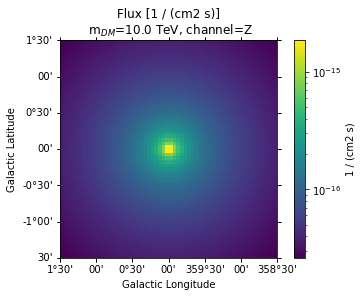

In [12]:
flux_map = WcsNDMap(geom=geom, data=int_flux.value, unit="cm-2 s-1")

fig, ax, im = flux_map.plot(cmap="viridis", norm=LogNorm(), add_cbar=True)
plt.title(
    f"Flux [{int_flux.unit}]\n m$_{{DM}}$={fluxes.mDM.to('TeV')}, channel={fluxes.channel}"
);